In [1]:
from matplotlib.pylab import *
from matplotlib import pyplot as plt
import numpy as np
import cv2
from collections import defaultdict
import time

In [2]:
%matplotlib inline

def plt_show_img(img, is_gray = False):
    figure(figsize=(7, 7))
    axis("off")
    imshow(img, cmap = plt.get_cmap('gray') if is_gray else None)

1. Создать средствами OpenCV бинарное изображение с простым рисунком.

(300, 300)

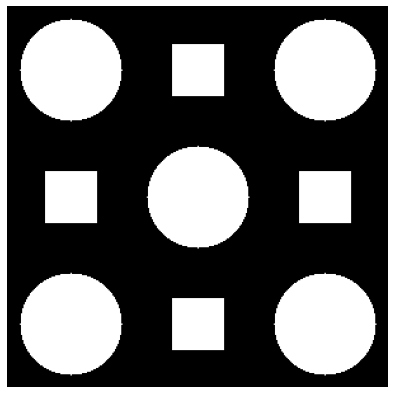

In [3]:
HEIGHT, WIDTH = 300, 300
img = np.full(shape=(HEIGHT, WIDTH), fill_value=0).astype(uint8)

cv2.circle(img, center=(50, 50), radius=40, color=1, thickness = -1)
cv2.circle(img, center=(150, 150), radius=40, color=1, thickness = -1)
cv2.circle(img, center=(250, 50), radius=40, color=1, thickness = -1)
cv2.circle(img, center=(50, 250), radius=40, color=1, thickness = -1)
cv2.circle(img, center=(250, 250), radius=40, color=1, thickness = -1)
cv2.rectangle(img, pt1=(30, 130), pt2=(70, 170), color=1, thickness = -1)
cv2.rectangle(img, pt1=(230, 130), pt2=(270, 170), color=1, thickness = -1)
cv2.rectangle(img, pt1=(130, 30), pt2=(170, 70), color=1, thickness = -1)
cv2.rectangle(img, pt1=(130, 230), pt2=(170, 270), color=1, thickness = -1)

plt_show_img(img, is_gray=True)
img.shape

2. Зашумить изображение импульсным шумом с вероятностью p (по вариантам).

In [24]:
def img_gaussian_noise(img, p=0.2, seed=54378643684727644864326634562):
    result = img.copy()
    rng = np.random.default_rng(seed)
    m, n = result.shape
    result = result.reshape(m*n)
    r_x = rng.choice(m*n, int(m*n*p))
    #gaussian[r_x] = 1
    result[r_x] = 1
    return result.reshape((m,n))

def noise_factor(img_1, img_2):
    return np.sum(img_1 != img_2) / (img_1.shape[0] * img_1.shape[1])

Коэффициент зашумленности: 0.11765555555555555


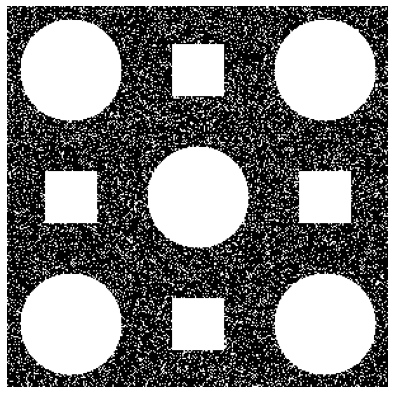

In [25]:
img_noisy = img_gaussian_noise(img, seed=time.time_ns())
plt_show_img(img_noisy, is_gray=True)
print(f"Коэффициент зашумленности: {noise_factor(img, img_noisy)}")

3. Написать функции реализации эрозии и дилатации вида fun(Image, struct), где struct - структурный элемент в виде матрицы.

In [26]:
def erosion(_img, struct=np.array([[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])):
    struct_indices = np.array(np.where(struct.flatten() > 0))
    struct_indices = struct_indices.reshape(struct_indices.shape[1])
    win_x, win_y = struct.shape
    img_x, img_y = _img.shape
    pad_x, pad_y = struct.shape[0] // 2, struct.shape[1] // 2
    img_sliding_window = np.lib.stride_tricks.sliding_window_view(np.pad(_img, [(pad_x, pad_x),(pad_y, pad_y)], mode='constant'), (win_x, win_y))
    img_sliding_window = img_sliding_window.reshape((img_x*img_y,win_x*win_y))[:, struct_indices].sum(axis=1)
    img_sliding_window[img_sliding_window < struct_indices.shape[0]] = 0
    img_sliding_window[img_sliding_window == struct_indices.shape[0]] = 1
    return img_sliding_window.reshape((img_x, img_y))

Коэффициент зашумленности: 0.047044444444444444


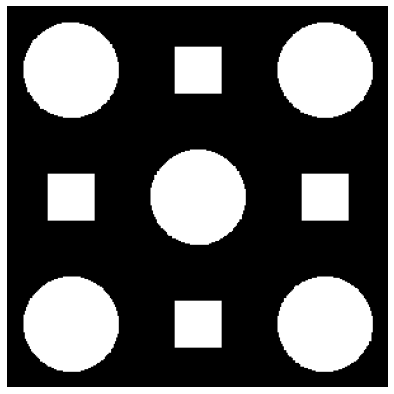

In [27]:
eroded_img = erosion(img_noisy)
plt_show_img(eroded_img, is_gray=True)
print(f"Коэффициент зашумленности: {noise_factor(img, eroded_img)}")

In [28]:
def dilation(_img, struct=np.array([[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])):
    struct_indices = np.array(np.where(struct.flatten() > 0))
    struct_indices = struct_indices.reshape(struct_indices.shape[1])
    win_x, win_y = struct.shape
    img_x, img_y = _img.shape
    pad_x, pad_y = struct.shape[0] // 2, struct.shape[1] // 2
    img_sliding_window = np.lib.stride_tricks.sliding_window_view(np.pad(_img, [(pad_x, pad_x),(pad_y, pad_y)], mode='constant'), (win_x, win_y))
    img_sliding_window = img_sliding_window.reshape((img_x*img_y,win_x*win_y))[:, struct_indices].sum(axis=1)
    img_sliding_window[img_sliding_window > 0] = 1
    return img_sliding_window.reshape((img_x, img_y))

Коэффициент зашумленности: 0.41424444444444447


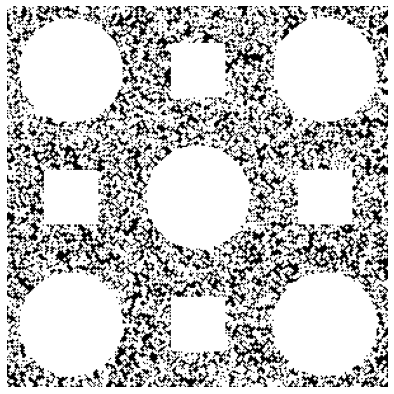

In [29]:
struct_el = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0],
])

dilated_img = dilation(img_noisy, struct=struct_el)
plt_show_img(dilated_img, is_gray=True)
print(f"Коэффициент зашумленности: {noise_factor(img, dilated_img)}")

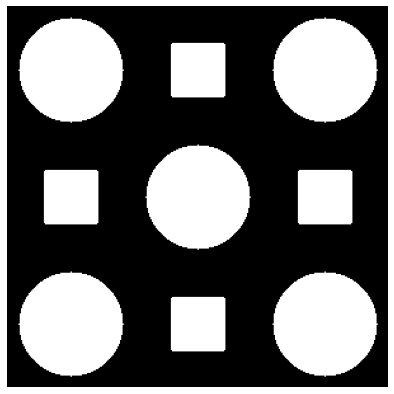

In [30]:
plt_show_img(dilation(img, struct=struct_el), is_gray=True)

In [31]:
def opening(input_img, struct=np.array([[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])):
    return dilation(erosion(input_img, struct), struct)

def closing(input_img, struct=np.array([[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])):
    return erosion(dilation(input_img, struct), struct)

Коэффициент зашумленности: 0.001488888888888889


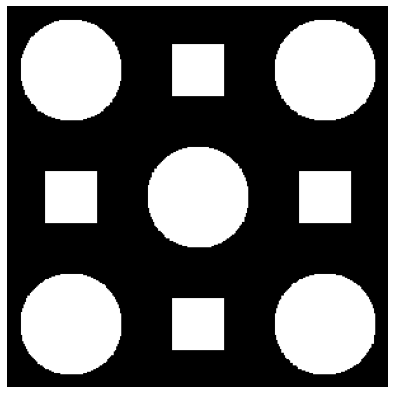

In [32]:
opening_img = opening(img_noisy)
plt_show_img(opening_img, is_gray=True)
print(f"Коэффициент зашумленности: {noise_factor(img, opening_img)}")

Коэффициент зашумленности: 0.5719555555555556


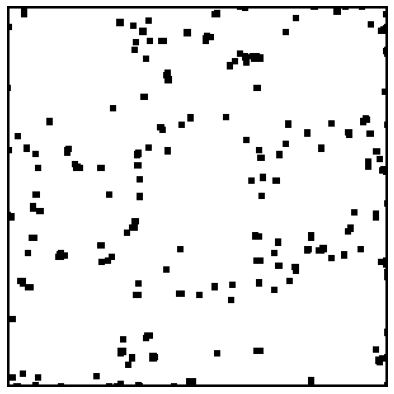

In [33]:
closing_img = closing(img_noisy)
plt_show_img(closing_img, is_gray=True)
print(f"Коэффициент зашумленности: {noise_factor(img, closing_img)}")

In [13]:
def logical_op(x):
    return (x[2] & (x[0] | x[1] | x[3] | x[4])) | ((~x[2]) & (x[0] & x[1] & x[3] & x[4])) 

struct=np.array([[0,1,0],[1,1,1],[0,1,0]])
struct_indices = np.array(np.where(struct.flatten() > 0))
struct_indices = struct_indices.reshape(struct_indices.shape[1])
win_x, win_y = struct.shape
img_x, img_y = img_noisy.shape
img_sliding_window = np.lib.stride_tricks.sliding_window_view(np.pad(img_noisy, [(1,1),(1,1)], mode='constant'), (win_x, win_y))
test_window = img_sliding_window.reshape((img_x*img_y,win_x*win_y)).copy()#[2500:2507]
#test_window = np.take_along_axis(test_window, struct_indices, axis=1)
test_window = test_window[:, struct_indices] != 0
test_window.shape
result = np.apply_along_axis(logical_op, 1, test_window)
result[result == True] = 1
result[result != True] = 0

In [14]:
def logical_op(x):
    return (x[2] & (x[0] | x[1] | x[3] | x[4])) | ((~x[2]) & (x[0] & x[1] & x[3] & x[4]))

def logic_filter(img, struct=np.array([[0,1,0],[1,1,1],[0,1,0]]), log_op=logical_op):
    struct_indices = np.array(np.where(struct.flatten() > 0))
    struct_indices = struct_indices.reshape(struct_indices.shape[1])
    win_x, win_y = struct.shape
    img_x, img_y = img_noisy.shape
    pad_x, pad_y = struct.shape[0] // 2, struct.shape[1] // 2
    img_sliding_window = np.lib.stride_tricks.sliding_window_view(np.pad(img_noisy, [(pad_x, pad_x),(pad_y, pad_y)], mode='constant'), (win_x, win_y))
    img_sliding_window = img_sliding_window.reshape((img_x*img_y,win_x*win_y))[:, struct_indices] != 0
    img_sliding_window = np.apply_along_axis(log_op, 1, img_sliding_window)
    return img_sliding_window.astype(uint8).reshape(img_x, img_y)

Коэффициент зашумленности: 0.06684444444444444


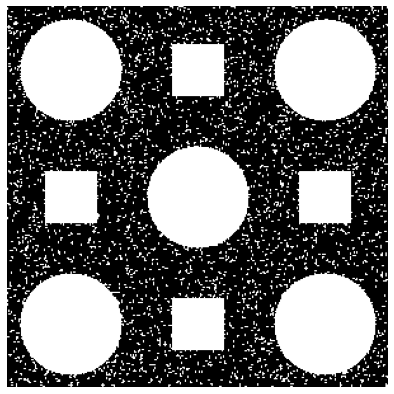

In [15]:
logic_img = logic_filter(img_noisy)
plt_show_img(logic_img, is_gray=True)
print(f"Коэффициент зашумленности: {noise_factor(img, logic_img)}")

Четырехсвязный внутренний контур


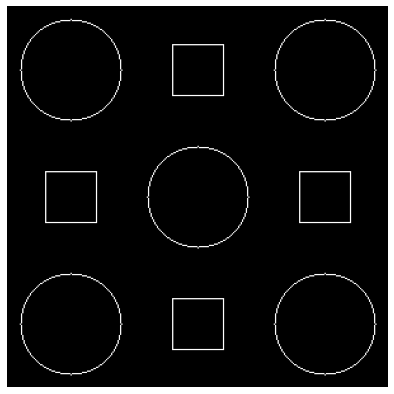

In [37]:
struct_el = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0],
])
eight_in_contour_img = (img + erosion(img, struct=struct_el)) % 2
plt_show_img(eight_in_contour_img, is_gray=True)
print("Четырехсвязный внутренний контур")

Восьмисвязный внутренний контур


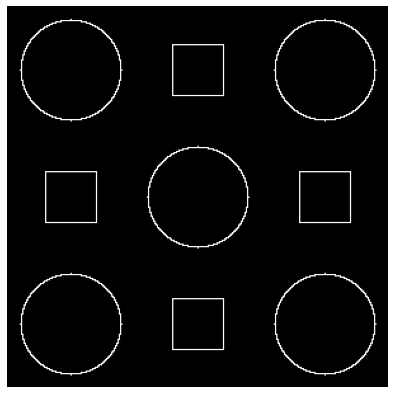

In [39]:
struct_el = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1],
])
four_in_contour_img = (img + erosion(img, struct=struct_el)) % 2
plt_show_img(four_in_contour_img, is_gray=True)
print("Восьмисвязный внутренний контур")

Внешний контур


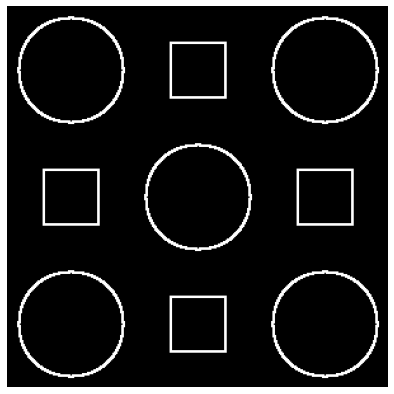

In [41]:
# struct_el = np.array([
#     [0, 1, 0],
#     [1, 1, 1],
#     [0, 1, 0],
# ])
# outer_contour_img = (img + dilation(img, struct=struct_el)) % 2
outer_contour_img = (img + dilation(img)) % 2
plt_show_img(outer_contour_img, is_gray=True)
print("Внешний контур")

Горизонтальные контуры изображения


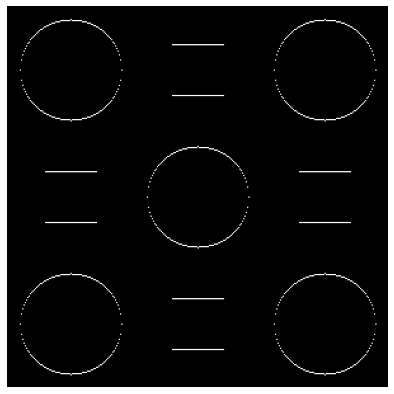

In [42]:
struct_el = np.array([
    [1],
    [1],
    [1],
])
ver_image = (img + erosion(img, struct=struct_el)) % 2
plt_show_img(ver_image, is_gray=True)
print("Горизонтальные контуры изображения")

Вертикальные контуры изображения


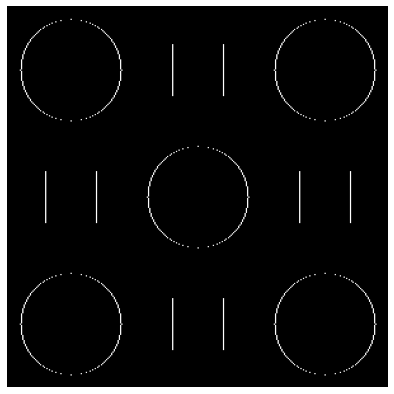

In [43]:
struct_el = np.array([
    [1,1,1]
])
ver_image = (img + erosion(img, struct=struct_el)) % 2
plt_show_img(ver_image, is_gray=True)
print("Вертикальные контуры изображения")